In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, chi2, chi2_contingency
import seaborn as sns

from sklearn.feature_selection import f_regression


In [2]:
diamonds = sns.load_dataset("diamonds")
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


### Funcion: describe_df

In [4]:
def funcion_describe(df):

    resultado = pd.DataFrame()
    """
    Obtiene información sobre porcentaje de cardinalidad, el tipo de datos, los valores únicos y el porcentaje de valores NaN en cada columna de un DataFrame.

    Args:
        df: El DataFrame del que se quiere obtener la información.

    Returns:
        Un diccionario con la información de cada columna.
    """
    for col in df.columns:
        datos = {}
        datos['%_cardinalidad'] = round(df[col].nunique() / len(df) * 100, 2)
        datos['Tipo_dato'] = df[col].dtype
        datos['valores_unicos'] = df[col].nunique()
        datos['%_NaN'] = round(df[col].isna().mean() * 100, 2)
        resultado[col] = pd.Series(datos)
    return resultado.transpose()

In [5]:
funcion_describe(diamonds)

,%_cardinalidad,Tipo_dato,valores_unicos,%_NaN
carat,0.51,float64,273,0.0
cut,0.01,category,5,0.0
color,0.01,category,7,0.0
clarity,0.01,category,8,0.0
depth,0.34,float64,184,0.0
table,0.24,float64,127,0.0
price,21.51,int64,11602,0.0
x,1.03,float64,554,0.0
y,1.02,float64,552,0.0
z,0.7,float64,375,0.0


### Funcion: tipifica_variables

In [6]:
def funcion_categorias(df):
    
    """
    Obtiene información sobre el tipo de categoria de cada columna de un DataFrame.

    Args:
        df: El DataFrame del que se quiere obtener la información.

    Returns:
        Un diccionario con la información de cada columna.
    """

    resultado = pd.DataFrame()
    for col in df.columns:
        datos = {}
        if pd.api.types.is_numeric_dtype(df[col]):
            datos['Categoria'] = 'Numerica Continua' if df[col].nunique() > 10 else 'Numérica Discreta'
        else:
            datos['Categoria'] = 'Categórica' if df[col].nunique() > 2 else 'Binaria'
   
        resultado[col] = pd.Series(datos)
    return resultado.transpose()

In [7]:
funcion_categorias(diamonds)

,Categoria
carat,Numerica Continua
cut,Categórica
color,Categórica
clarity,Categórica
depth,Numerica Continua
table,Numerica Continua
price,Numerica Continua
x,Numerica Continua
y,Numerica Continua
z,Numerica Continua


In [8]:
diamonds.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

  ### funcion get_features_num_regression

In [9]:
def get_features_num_regression(df, target_col,umbral_corr = 0.5, pvalue = None):
    """
    Devuelve una lista con las columnas numéricas del dataframe cuya correlación con la columna designada por "target_col" sea superior en valor absoluto al valor dado por "umbral_corr".

    Args:
        df: El DataFrame del que se quiere obtener las características correlacionadas.
        target_col: El nombre de la columna objetivo.
        umbral_corr= cantidad numerico entre 0 a 1
    
    Returns:
        Una lista con las columnas correlacionadas.
    """
    # comprbamos en una lista de comprensión si todas son columnas numericas (true o false)
    columnas_num = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    #verificacion de columnas no numericas, describiendo el tipo y descartamos éstas
    columnas_no_num= set(df.columns) - set(columnas_num)
    if columnas_no_num:
        print("Las columnas no numéricas descartadas en esta función son:", columnas_no_num)
        df= df[columnas_num]
    
    # Calculamos las correlaciones y p-values utilizando f_regression, sin la target, obteniendo la X en la funcion de regresión .
    _, p_values = f_regression(df.drop(columns=[target_col]), df[target_col])

    # Filtramos las columnas según el umbral_corr y p-value, incluyendo la target nuevamente en la lista de correlaciones
    columnas_correlacionadas_dir = df.columns[(df.corr()[target_col] >= umbral_corr)].tolist()
    columnas_correlacionadas_indir = df.columns[(df.corr()[target_col] >= -(umbral_corr))].tolist()

    # Filtramos por significancia si se proporciona un p-value, agrupando columnas con su p_values
    if pvalue is not None:
        columnas_correlacionadas_dir = [col for col, p_val in zip(columnas_correlacionadas_dir, p_values) if p_val <= pvalue]
        columnas_correlacionadas_indir = [col for col, p_val in zip(columnas_correlacionadas_indir, p_values) if p_val <= pvalue]

    nl ='\n'
    print(f"Las columnas numéricas con |valor de correlación superior| a {umbral_corr} aportado en la variable 'umbral_corr' en referencia a {target_col} son: {nl}Directamente proporcionales:   {columnas_correlacionadas_dir} {nl}Indirectamente proporcionales: {columnas_correlacionadas_indir}")


In [10]:
get_features_num_regression(diamonds, "price",umbral_corr=0.5, pvalue=None)

Las columnas no numéricas descartadas en esta función son: {'clarity', 'cut', 'color'}
Las columnas numéricas con |valor de correlación superior| a 0.5 aportado en la variable 'umbral_corr' en referencia a price son: 
Directamente proporcionales:   ['carat', 'price', 'x', 'y', 'z'] 
Indirectamente proporcionales: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


In [11]:
corr_gold1=diamonds.corr(numeric_only=True)["price"].sort_values(ascending = False)
corr_abs_gold1= np.abs(diamonds.corr(numeric_only=True)["price"].sort_values(ascending = False))*100
round(corr_abs_gold1, 2)

price    100.00
carat     92.16
x         88.44
y         86.54
z         86.12
table     12.71
depth      1.06
Name: price, dtype: float64

### Funcion: plot_features_num_regression

In [12]:
def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Crea un conjunto de pair plots para visualizar las correlaciones entre las columnas numéricas del DataFrame.

    Args:
        df: El DataFrame del que se quiere visualizar las correlaciones.
        target_col: El nombre de la columna objetivo.
        umbral_corr= numbral maximo establecido de correlacion con la target
        pvalue: El valor de p-valor.

    Returns:
        None
    """

    columnas_para_pintar = []
    columnas_umbral_mayor = []

    #iteramos por la columnas
    for col in columns:
        #si en la iteracion de las columnas del DF y siempre que...
        # se comprube si son numéricas(true) o no son numéricas(false)
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # usando el indice de correlación de Pearson y el p-valor(funcion pearsonr)
            # calculamos dichos parametros para target y resto de columnas
            corr, pv = pearsonr(df[col], df[target_col])
            if abs(corr) > umbral_corr:
                columnas_umbral_mayor.append(col)
                if pvalue is None or pv < pvalue:
                    columnas_para_pintar.append(col)

    # Número máximo de gráficas por grupo
    max_graficas_por_grupo = 6

    # Dividir en grupos según el número máximo de gráficas
    len(columnas_para_pintar) // max_graficas_por_grupo
    # En un alista de comprension, iteramos en rango desde 0 hasta el numero de columnas a pintar, por cada grupo maximo establecido
    # creando graficas con columnas maxi de i+ grupo max establecido ( ejem: '0 hasta 0+6)
    columnas = [columnas_para_pintar[i:i+max_graficas_por_grupo] for i in range(0, len(columnas_para_pintar), max_graficas_por_grupo)]

    # iteramos por i y por valor 'umbral_corr' establecido a cada grupo en cada iteración,  creeando pair plots para cada grupo,
    for i, grupo in enumerate(columnas):
        sns.pairplot(df, vars=grupo, hue=target_col)
        plt.suptitle(f"Group {i}", y=1.02)# creo nombres de grupo un poco por encima de y, para que no se superponga con la gráfica
        plt.show()
    
    return "Las columnas con un mayor umbral_corr al establecido son", columnas_umbral_mayor



In [13]:
for col in diamonds.columns:
    if pd.api.types.is_numeric_dtype(diamonds[col]):
    # Calcular la correlación de Pearson
        corr, pv = pearsonr(diamonds[col], diamonds["x"])

        print("Correlación de Pearson:", corr)
        print("Valor p:", pv)

Correlación de Pearson: 0.975094226726579
Valor p: 0.0
Correlación de Pearson: -0.025289246978949964
Valor p: 4.248196867068168e-09
Correlación de Pearson: 0.19534428095549208
Valor p: 0.0
Correlación de Pearson: 0.88443516101616
Valor p: 0.0
Correlación de Pearson: 1.0
Valor p: 0.0
Correlación de Pearson: 0.9747014796703822
Valor p: 0.0
Correlación de Pearson: 0.9707717985774985
Valor p: 0.0


In [14]:
diamonds.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

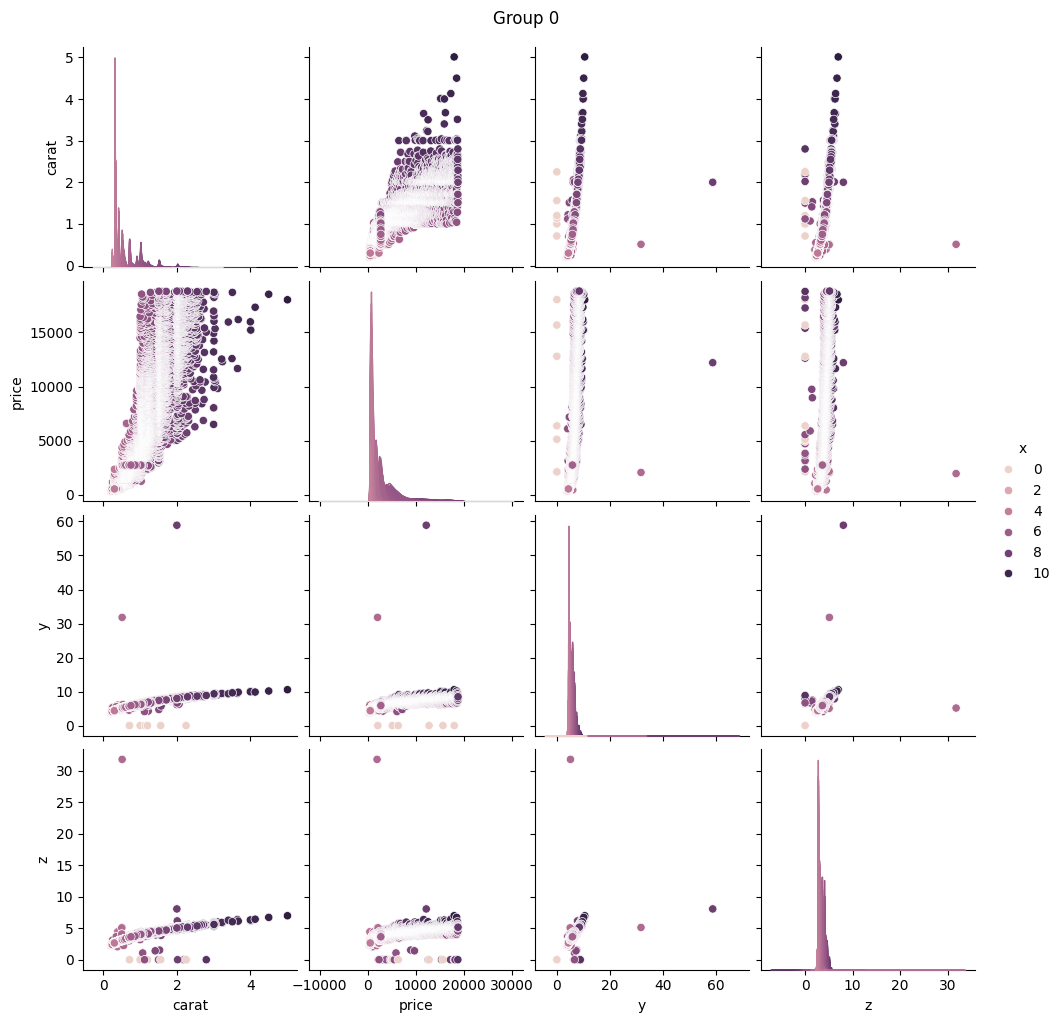

('Las columnas con un mayor umbral_corr al establecido son',
 ['carat', 'price', 'y', 'z'])

In [15]:
plot_features_num_regression(diamonds,"x", columns=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', "y", "z"], umbral_corr=0.5, pvalue=None)

### Funcion: get_features_cat_regression

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway

def get_features_cat_regression(dataframe: pd.DataFrame, target_col: str, pvalue: float = 0.05) -> list:
    """
    Esta función recibe un dataframe y dos argumentos adicionales: 'target_col' y 'pvalue'.
    
    Parámetros:
    - dataframe: DataFrame de pandas.
    - target_col: Nombre de la columna que actuará como el objetivo para un modelo de regresión.
    - pvalue: Valor de p umbral para la significancia estadística (por defecto es 0.05).
    
    Devuelve:
    - Una lista con las columnas categóricas cuya relación con 'target_col' es estadísticamente significativa.
    - None si hay errores en los parámetros de entrada.
    """
    # Comprueba si 'target_col' es una columna numérica válida en el dataframe
    if target_col not in dataframe.columns or not pd.api.types.is_numeric_dtype(dataframe[target_col]):
        print(f"Error: '{target_col}' no es una columna numérica válida en el dataframe.")
        return None
    
    # Comprueba si 'pvalue' es un float válido
    if not isinstance(pvalue, float):
        print("Error: 'pvalue' debería ser un float.")
        return None
    
    # Identifica las columnas categóricas
    cat_columns = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Comprueba si hay columnas categóricas
    if not cat_columns:
        print("Error: No se encontraron columnas categóricas en el dataframe.")
        return None
    
    # Realiza pruebas estadísticas y filtra columnas basadas en el valor de p
    selected_columns = []
    for cat_col in cat_columns:
        contingency_table = pd.crosstab(dataframe[cat_col], dataframe[target_col])
        
        # Elige la prueba apropiada según la cardinalidad
        if len(contingency_table) > 2:
            _, p, _, _ = chi2_contingency(contingency_table)
        else:
            _, p = f_oneway(*[dataframe[target_col][dataframe[cat_col] == category] for category in dataframe[cat_col].unique()])
        
        if p < pvalue:
            selected_columns.append(cat_col)
    
    return selected_columns




In [83]:
get_features_cat_regression(diamonds, "x", pvalue=0.05)


['cut', 'color', 'clarity']

### Funcion: plot_features_cat_regression

In [84]:
def plot_features_cat_regression(dataframe: pd.DataFrame, target_col: str = "", 
                                  columns: list = [], pvalue: float = 0.05, 
                                  with_individual_plot: bool = False) -> list:
    """
    Esta función recibe un dataframe y varios argumentos opcionales para visualizar y analizar la relación
    entre variables categóricas y una columna objetivo en un modelo de regresión.

    Parámetros:
    - dataframe: DataFrame de pandas.
    - target_col: Nombre de la columna que actuará como el objetivo para un modelo de regresión.
    - columns: Lista de nombres de columnas categóricas a considerar (por defecto, todas las numéricas).
    - pvalue: Valor de p umbral para la significancia estadística (por defecto es 0.05).
    - with_individual_plot: Booleano que indica si se deben incluir gráficos individuales para cada columna (por defecto es False).

    Devuelve:
    - Una lista con las columnas seleccionadas que cumplen con las condiciones de significancia.
    - None si hay errores en los parámetros de entrada.
    """
    # Comprueba si 'target_col' es una columna numérica válida en el dataframe
    if target_col and (target_col not in dataframe.columns or not pd.api.types.is_numeric_dtype(dataframe[target_col])):
        print(f"Error: '{target_col}' no es una columna numérica válida en el dataframe.")
        return None
    
    # Comprueba si 'pvalue' es un float válido
    if not isinstance(pvalue, float):
        print("Error: 'pvalue' debería ser un float.")
        return None
    
    # Comprueba si 'columns' es una lista válida de strings
    if not isinstance(columns, list) or not all(isinstance(col, str) for col in columns):
        print("Error: 'columns' debería ser una lista de strings.")
        return None
    
    # Comprueba si 'with_individual_plot' es un booleano válido
    if not isinstance(with_individual_plot, bool):
        print("Error: 'with_individual_plot' debería ser un booleano.")
        return None
    
    # Si 'columns' está vacío, utiliza todas las columnas numéricas en el dataframe
    if not columns:
        columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    
    # Filtra columnas basadas en pruebas estadísticas
    selected_columns = get_features_cat_regression(dataframe, target_col, pvalue)
    selected_columns = list(set(selected_columns) & set(columns))
    
    if not selected_columns:
        print("Ninguna columna cumple con las condiciones especificadas para trazar.")
        return None
    
    # Histogramas
    for cat_col in selected_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=dataframe, x=target_col, hue=cat_col, multiple="stack", kde=True)
        plt.title(f"Histograma para {target_col} por {cat_col}")
        plt.show()
    
    return selected_columns


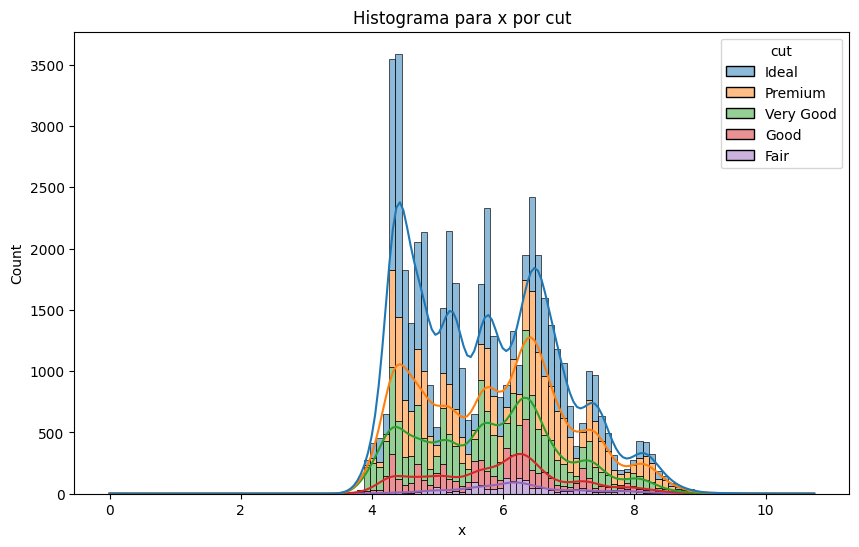

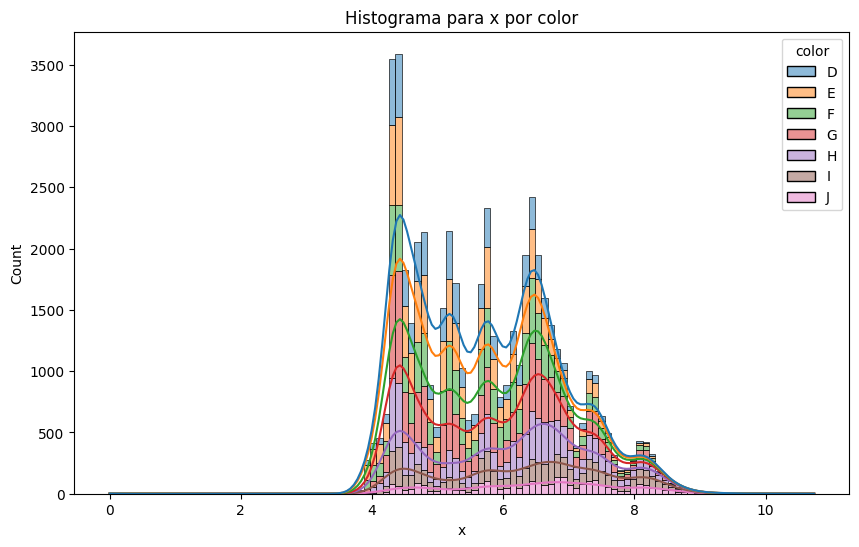

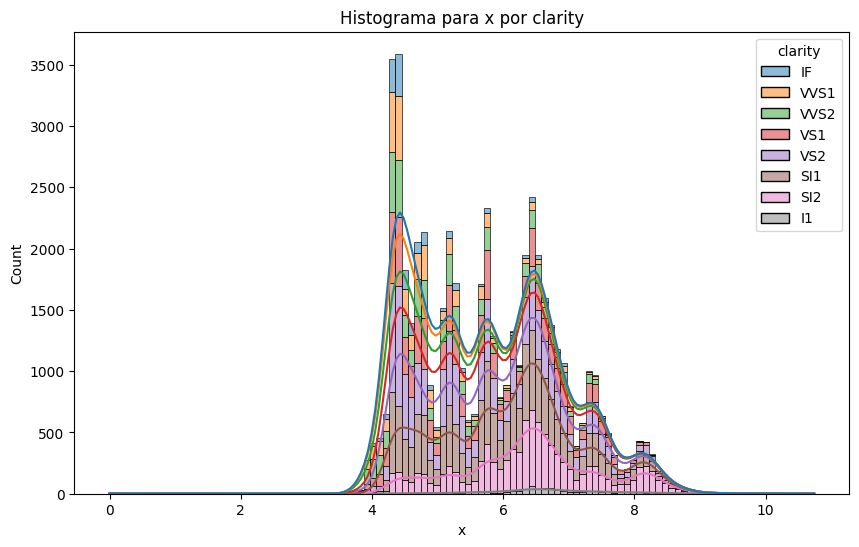

['cut', 'color', 'clarity']

In [85]:
selected_cols = get_features_cat_regression(diamonds, "x", pvalue=0.05)
plot_features_cat_regression(diamonds, 'x', columns=selected_cols, with_individual_plot=True)